Compute SVD as $\sum_{i=1}^r \lambda_i u_i v_i^\top$, and return $u_i v_i^\top$ as the $i$-th eigenbasis. 

In [55]:
import numpy as np

def compute_eigenbasis(i, mat):
    """
    i-th eigenbasis
    """
    U, S, Vt = np.linalg.svd(mat, full_matrices=False)
    if i < len(S):
        u_i = U[:, i].reshape(-1, 1)
        v_i = Vt[i, :].reshape(1, -1)
        eigenbasis = np.dot(u_i, v_i)
        return eigenbasis
    else:
        return None

Pick $r = O(\log d)$ eigenvalues such that $\kappa = 1/d^2$ and $\lambda_i \approx 2 \lambda_{i+1}$, then pick $U, V$ uniformly at random, get $A = U S V^\top \in \mathbb{R}^{r \times d}$
Make $A$ full rank and symmetric by setting $A := AA^\top$ 

In [56]:
# Generate a poorly conditioned random matrix, enforce "halfing" eigenvalue sequence

d = 2000
col = d
factor = 1.3

kappa = 1/d**2 # want this to be "poly d"
s = [1]
while s[-1] > factor * kappa:
  s += [s[-1]/factor]

row = len(s)

# generate a random basis, U of dimension row x row

U_rand = np.random.randn(row, row)  # rxr matrix with normal distribution

# Perform QR decomposition to obtain an orthonormal basis
U, _ = np.linalg.qr(U_rand)

V_rand = np.random.randn(col, row)
V, _ = np.linalg.qr(V_rand)

random_matrix = np.dot(np.dot(U, np.diag(s)), V.T)
row_norms = np.linalg.norm(random_matrix, axis=1, keepdims=True)  # Compute row-wise norms
# random_matrix = random_matrix / row_norms

# symmetrize, full rank
random_matrix = random_matrix @ random_matrix.T

U, S, Vt = np.linalg.svd(random_matrix, full_matrices=False)
print("Kappa: ", S[0]/S[-1])
print(S.shape[0])
print(random_matrix.shape[0], random_matrix.shape[1])


Kappa:  9762299722882.303
58
58 58


In [57]:
import numpy as np

def conjugate_gradient(iter, mat, b=None, random=True, n=10, lbp=False):
    row, col = mat.shape
    dtype = np.float16 if lbp else np.float64  # Use lower precision if lbp is enabled

    # Ensure b is a (row,1) column vector
    if b is None:
        b = np.zeros((row, 1), dtype=dtype)
    
    # Ensure x is a (col,1) column vector
    x = np.random.rand(col, 1).astype(dtype) if random else np.zeros((col, 1), dtype=dtype)
    x = x / np.linalg.norm(x).astype(dtype)

    iterates = [x]
    r = (b - np.matmul(mat, x)).astype(dtype)
    p = r.astype(dtype)

    for i in range(iter):
        alpha = (np.linalg.norm(r) ** 2 / np.matmul(p.T, np.matmul(mat, p))).astype(dtype)
        x = (x + alpha * p).astype(dtype)  # Keep x as (col,1) with the correct dtype

        new_r = (r - alpha * np.matmul(mat, p)).astype(dtype)  # residual
        beta = (np.linalg.norm(new_r) ** 2) / (np.linalg.norm(r) ** 2)
        beta = beta.astype(dtype)
        
        p = (new_r + beta * p).astype(dtype)
        r = new_r.astype(dtype)

        if i % n == 0:
            iterates.append(x)

    return iterates


In [58]:
import matplotlib.pyplot as plt

# if proj_iterates has r rows (for each eigenvalue) and t columns (for each iterate), visualize the first k using "top k"
# visiualize just the last row (bottom eigenspace) using min_k = 1000000 and top_k= 1000000 (some large numbers)
def plot_projections(proj_iterates, min_k=0, top_k=3, n=10, title="Title Missing"):
    nums = [i * n for i in range(len(proj_iterates[0]))]

    # Define a color map for distinct colors
    colors = plt.cm.viridis(np.linspace(0, 1, top_k))

    # plt.figure(figsize=(8, 6))  # Set figure size

    if min_k > len(proj_iterates):
        min_k = len(proj_iterates) - 1
        
    for k in range(min_k, min(len(proj_iterates), top_k)):
        plt.plot(nums, [proj_iterates[k][i] for i in range(len(proj_iterates[0]))],
                 color=colors[k], label=f"Eigenvector {k+1}", linewidth=2)

    plt.xlabel("Iterations")
    plt.ylabel("Projection")
    plt.legend(title="Eigenspace")  # Add legend title
    plt.title(title)
    plt.show()

    return 0


In [59]:
# # Generate a square, PSD matrix for conjugate gradient
# d = 200
# rows, cols = d, d

# # Generate a random matrix
# random_matrix = np.random.rand(rows, cols)
# random_matrix = np.matmul(random_matrix, random_matrix.T)


# # top eigenspace, for example
# _ = compute_eigenbasis(0, random_matrix)

# U, S, Vt = np.linalg.svd(random_matrix, full_matrices=False)
# kappa = S[0]/S[-1]
# print(kappa)
# print(S.shape[0])

Here, normalized iterates are the directions generated by CGD. We look at the fraction of the direction projected onto each of the eigenspaces. For example, if the iterate was $x = (1, 1)$ and the top two spaces were span $(1, 0)$ and $(0, 1)$ repsectively, then we should see two lines at $1/\sqrt{2}$. Eventually, a good solver (like CGD) should send all the projection to the smallest eigenspace, which is what we see happen!

In [60]:
steps = 70
iterates = conjugate_gradient(steps, random_matrix, n=1, lbp=True)
print(random_matrix.shape)
print(len(iterates))

print(iterates[0].shape)
# best rank k approx; top k eigenbases
rank_k = [compute_eigenbasis(k, random_matrix) for k in range(S.shape[0])]
# print(rank_k[0].shape)

# project the iterates onto each of the eigenspaces
normalized_iterates = [iterates[i]/np.linalg.norm(iterates[i]) for i in range(len(iterates))]
proj_iterates = [[np.matmul(rank_k[k], normalized_iterates[i]) for i in range(len(normalized_iterates))] for k in range(len(rank_k))]
norm_proj_iterates = [[np.linalg.norm(np.matmul(rank_k[k], normalized_iterates[i])) for i in range(len(normalized_iterates))] for k in range(len(rank_k))]

(58, 58)
71
(58, 1)


/var/folders/fx/2slzxsm103l596vsry2cthbc0000gn/T/ipykernel_27752/916550318.py:24: RuntimeWarning: invalid value encountered in scalar divide
  beta = (np.linalg.norm(new_r) ** 2) / (np.linalg.norm(r) ** 2)


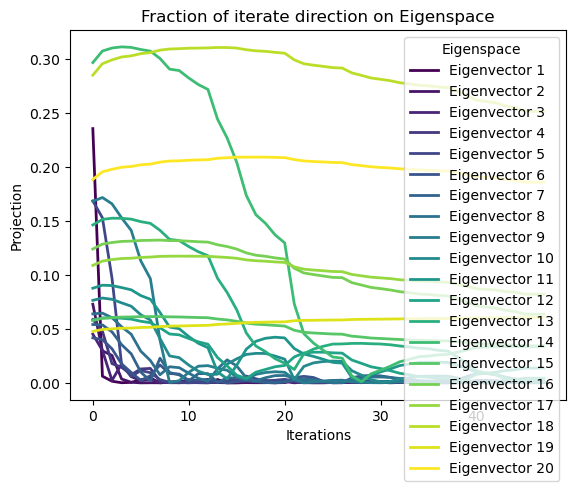

71


In [61]:
# plot progress (put a very large number for top_k to see all eigenvalues)
# plot_projections(smoothed2, top_k=6, n=1)
plot_projections(norm_proj_iterates, top_k=20, n=1, title="Fraction of iterate direction on Eigenspace")

print(len(norm_proj_iterates[:][5]))

Correlations measures the correlation between consecutive projections on an eigenbasis. Suppose that the projections onto the $k$-th eigenspace were $x_{1, k}, x_{2, k}, ...$, then we would measure 
$\frac{\langle x_{i, k}, x_{i-1, k} \rangle}{\|x_{i, k} \| \|x_{i-1, k} \|}$, the cosine anglne between them. If these are all close to 1, the iterates do not "flip" with respect to the $k$-th eigenspace. 

In [62]:
correlations = []
# take components on each of the eigenspaces
for s in range(S.shape[0]):
    # plot correlations
    correlation_k = []
    for i in range(1, len(proj_iterates[s])):
        ip = (proj_iterates[s][i].T @ proj_iterates[s][i-1]) / (norm_proj_iterates[s][i] * norm_proj_iterates[s][i-1])
        correlation_k.append(ip.item())

    correlations.append(correlation_k)


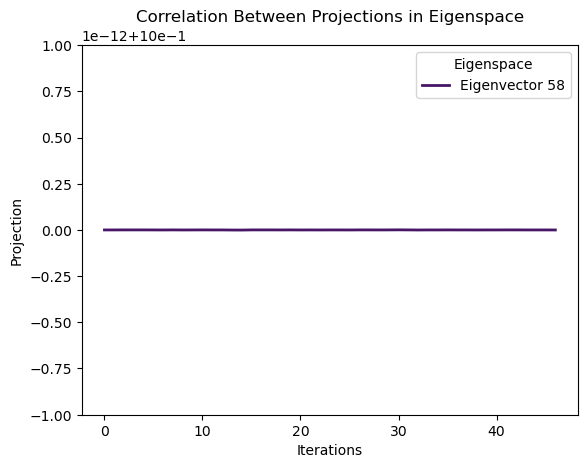

[[nan]]
[1.0, 0.9999999999999997, 1.0, 1.0000000000000002, 1.0, 1.0, 1.0, 0.9999999999999998, 1.0, 1.0000000000000002, 0.9999999999999999, 1.0, 1.0, 1.0000000000000002, 1.0, 0.9999999999999997, 1.0, 1.0000000000000002, 0.9999999999999999, 1.0000000000000002, 0.9999999999999999, 1.0000000000000002, 1.0000000000000002, 1.0000000000000002, 1.0000000000000002, 1.0000000000000002, 1.0000000000000002, 1.0000000000000002, 0.9999999999999999, 1.0, 1.0000000000000002, 0.9999999999999999, 0.9999999999999999, 0.9999999999999998, 1.0, 1.0, 1.0, 1.0000000000000002, 1.0000000000000002, 1.0000000000000002, 1.0000000000000002, 1.0000000000000002, 1.0000000000000002, 1.0, 0.9999999999999997, 1.0, 1.0000000000000002, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]


In [64]:

plot_projections(correlations, min_k=1000, top_k=1000, n=1, title="Correlation Between Projections in Eigenspace")

# first and last iterate cosine similarity
print((proj_iterates[-1][0].T @ proj_iterates[-1][-1]) / (norm_proj_iterates[-1][0] * norm_proj_iterates[-1][-1]))


print(correlations[30])